# 按飛行時間分類

**飛行時間組合出現的次數**

In [10]:
import pandas as pd
import numpy as np
import re

# 讀取資料
data_path = '/Users/yuchingchen/Documents/專題/cleaned_data/sydney.csv'
df = pd.read_csv(data_path)

# 提取飛行時間和停留時間的小時數
def extract_hours_and_minutes(time_str):
    """從時間字串提取小時數和分鐘數"""
    hours = re.search(r'(\d+) 小時', time_str)
    minutes = re.search(r'(\d+) 分鐘', time_str)
    hours = int(hours.group(1)) if hours else 0
    minutes = int(minutes.group(1)) if minutes else 0
    return hours + minutes / 60

# 計算「飛行時間_小時」
df['飛行時間_小時'] = df['飛行時間'].apply(lambda x: extract_hours_and_minutes(x))

# 計算「停留時間_小時」，如果是 Non-stop 設為 0
df['停留時間_小時'] = df['停留時間'].apply(lambda x: extract_hours_and_minutes(x) if 'Non-stop' not in x else 0)

# 計算實際飛行時間：飛行時間扣除停留時間
df['實際飛行時間'] = df['飛行時間_小時'] - df['停留時間_小時']

# 確保 Non-stop (直達航班) 的實際飛行時間不扣除停留時間
df.loc[df['停留時間'].str.contains('Non-stop', na=False), '實際飛行時間'] = df['飛行時間_小時']

# 使用 qcut 分組，避免分位數重複
df['飛行時間_分組'] = pd.qcut(df['實際飛行時間'], q=3, labels=['短程', '中程', '長程'], duplicates='drop')

# 統計各組的數據量
group_counts = df['飛行時間_分組'].value_counts().sort_index()

# 輸出結果
print("各組數據量分布：")
print(group_counts)

print("\n分組後的數據示例：")
print(df[['飛行時間', '停留時間', '飛行時間_小時', '停留時間_小時', '實際飛行時間', '飛行時間_分組']].head())

# 取對數處理
df['平均價格_log'] = df['平均價格'].apply(lambda x: np.log1p(x) if x > 0 else 0)
df['最低價格_log'] = df['最低價格'].apply(lambda x: np.log1p(x) if x > 0 else 0)
df['中位數價格_log'] = df['中位數價格'].apply(lambda x: np.log1p(x) if x > 0 else 0)
df['價格變異_log'] = df['價格變異'].apply(lambda x: np.log1p(x) if x > 0 else 0)
df["最低價格天數"] = df["最低價格剩餘天數"].apply(lambda x: 91-x if pd.notnull(x) and x != 0 else np.nan)

# 移除包含 NaN 的數據
plot_data = df.dropna(subset=["平均價格_log", "最低價格_log", "最低價格天數", "價格變異_log", "中位數價格_log", "實際飛行時間"])

各組數據量分布：
飛行時間_分組
短程    1968
中程    1427
長程    1668
Name: count, dtype: int64

分組後的數據示例：
          飛行時間         停留時間    飛行時間_小時    停留時間_小時     實際飛行時間 飛行時間_分組
0  29 小時 30 分鐘  18 小時 20 分鐘  29.500000  18.333333  11.166667      中程
1  21 小時 15 分鐘   9 小時 55 分鐘  21.250000   9.916667  11.333333      中程
2   9 小時 20 分鐘     Non-stop   9.333333   0.000000   9.333333      短程
3  13 小時 20 分鐘   2 小時 10 分鐘  13.333333   2.166667  11.166667      中程
4  12 小時 45 分鐘   1 小時 35 分鐘  12.750000   1.583333  11.166667      短程


**處理後：Boxplot（按飛行時間分類）**

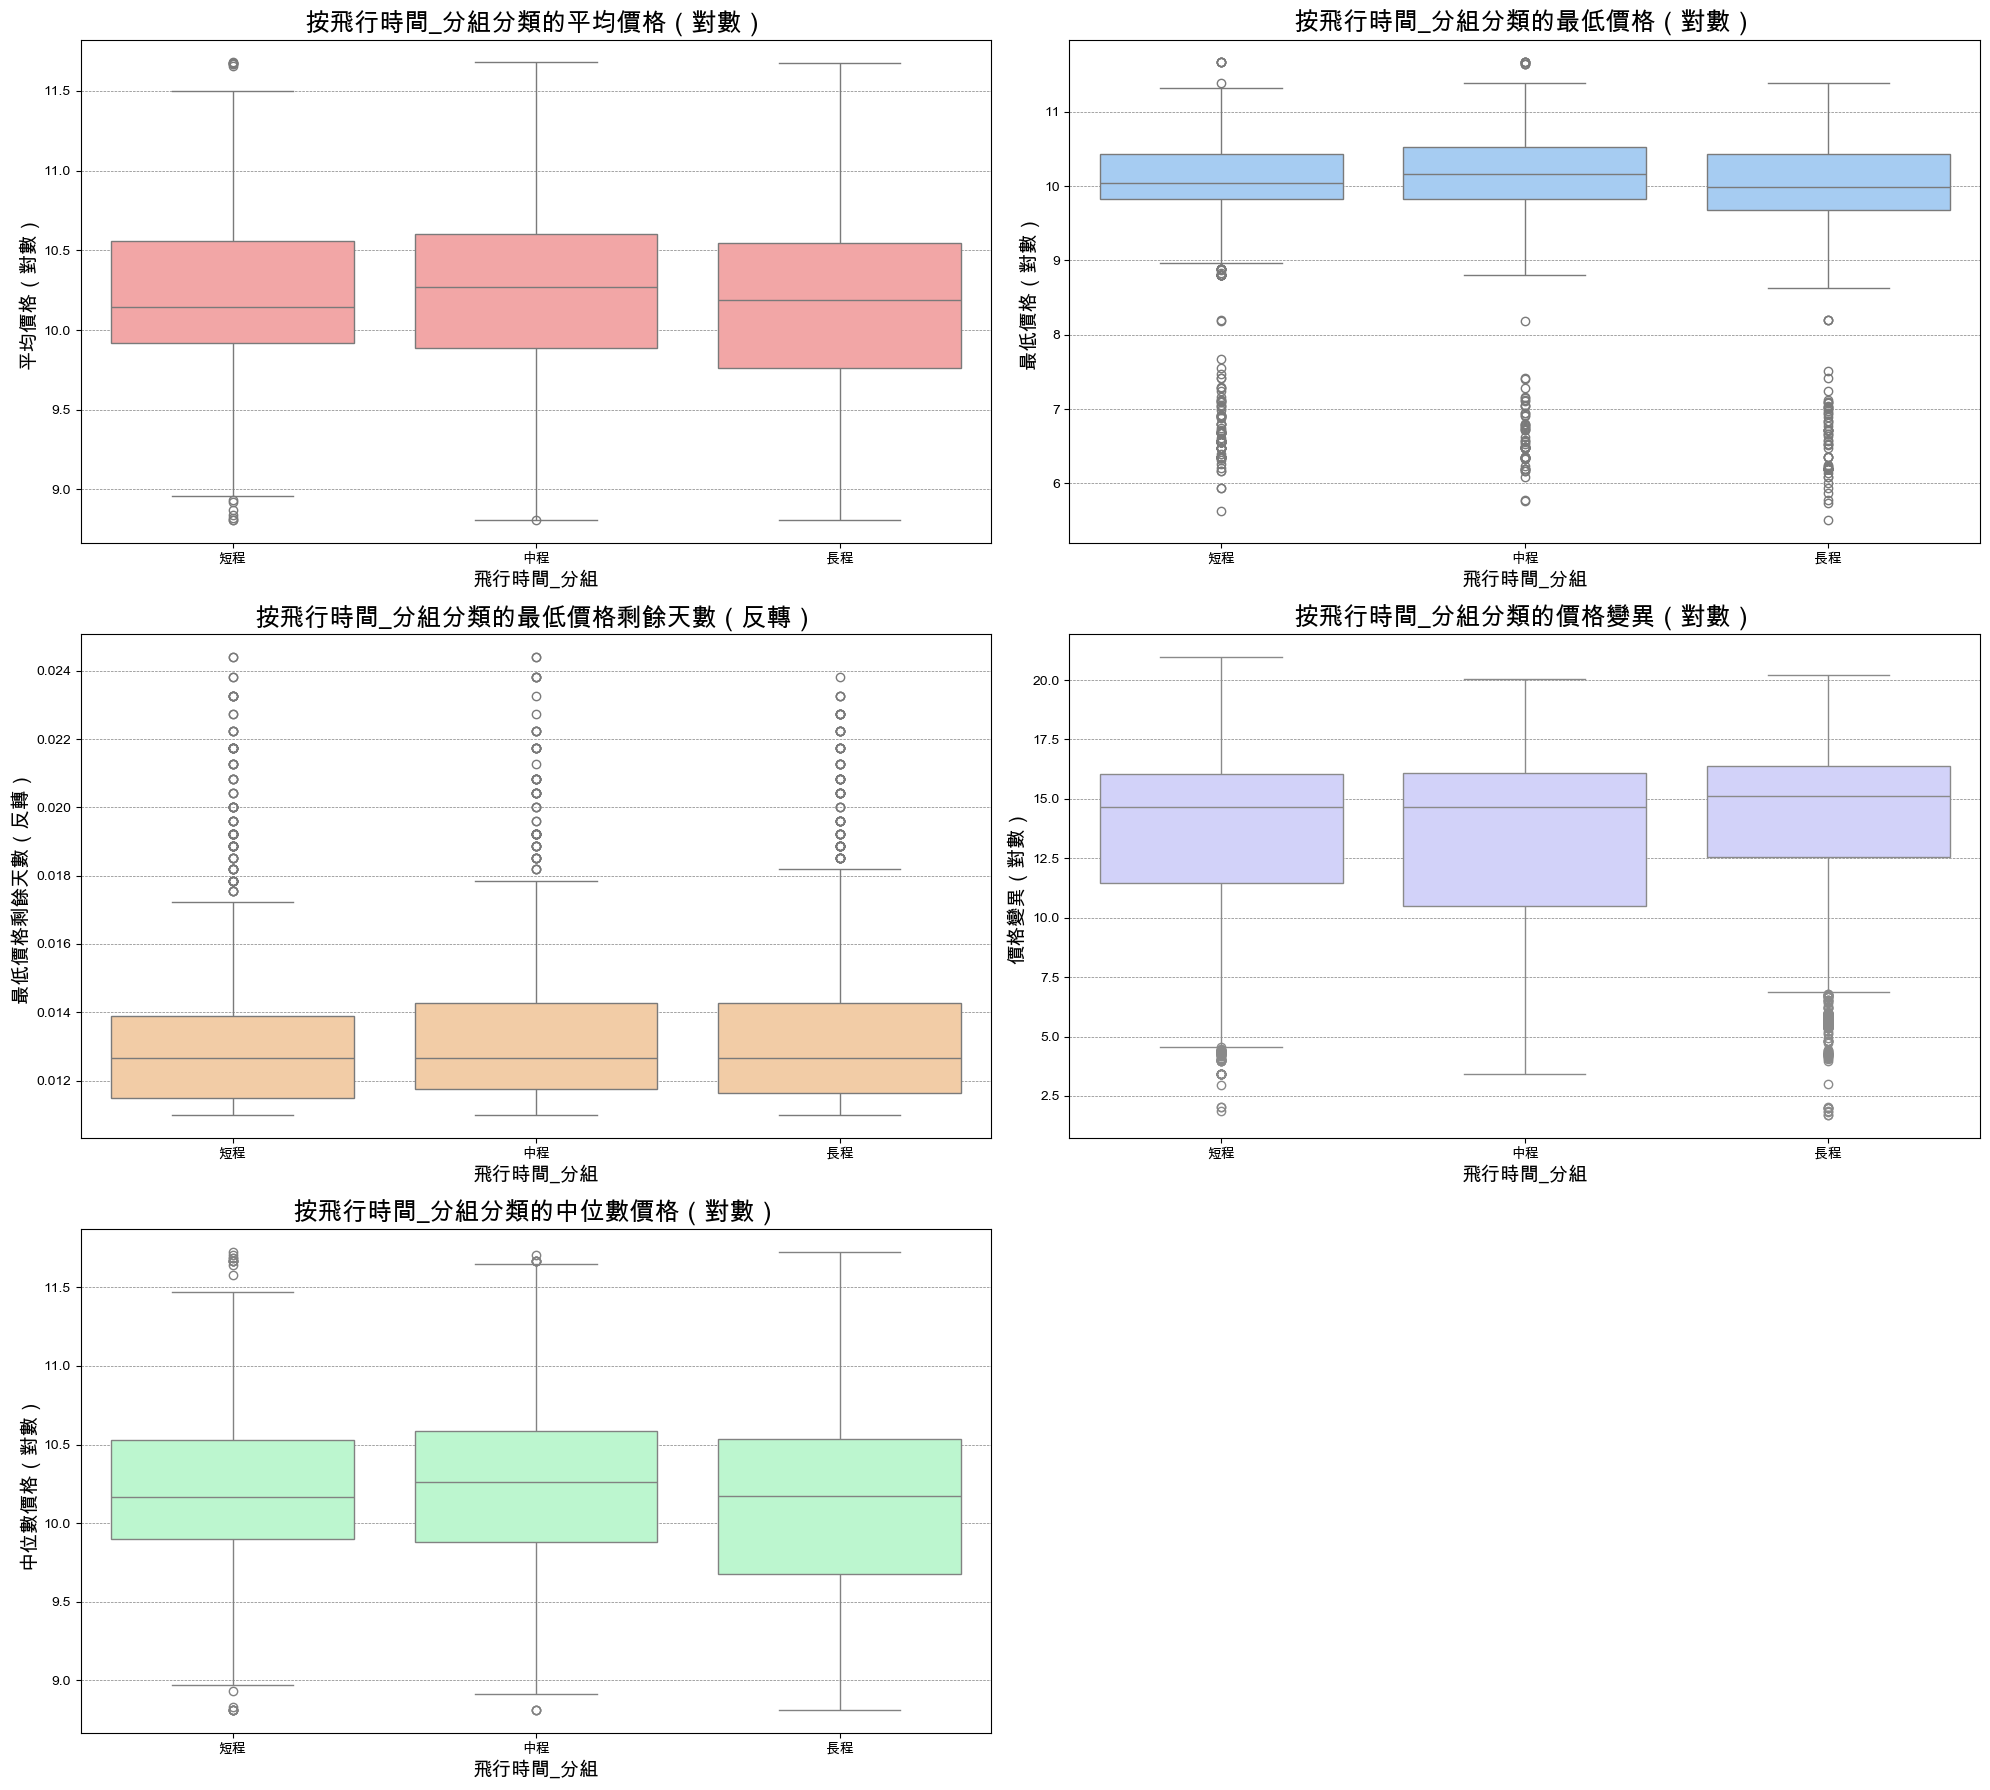

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 繁體中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 設定排序順序
plot_data['飛行時間_分組'] = pd.Categorical(
    plot_data['飛行時間_分組'],
    categories=['短程', '中程', '長程'],
    ordered=True
)

# 創建子圖，分別繪製對數轉換後的盒狀圖
fig, axes = plt.subplots(3, 2, figsize=(20, 18))  # 更新為 3x2 網格

# 調整圖表標題字體大小
title_fontsize = 18
label_fontsize = 14

# 第一個子圖：按飛行時間_分組分類的平均價格的盒狀圖（對數）
sns.boxplot(data=plot_data, x='飛行時間_分組', y='平均價格_log', ax=axes[0, 0], color='#FF9999')
axes[0, 0].set_title('按飛行時間_分組分類的平均價格（對數）', fontsize=title_fontsize)
axes[0, 0].set_xlabel('飛行時間_分組', fontsize=label_fontsize)
axes[0, 0].set_ylabel('平均價格（對數）', fontsize=label_fontsize)
axes[0, 0].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 第二個子圖：按飛行時間_分組分類的最低價格的盒狀圖（對數）
sns.boxplot(data=plot_data, x='飛行時間_分組', y='最低價格_log', ax=axes[0, 1], color='#99CCFF')
axes[0, 1].set_title('按飛行時間_分組分類的最低價格（對數）', fontsize=title_fontsize)
axes[0, 1].set_xlabel('飛行時間_分組', fontsize=label_fontsize)
axes[0, 1].set_ylabel('最低價格（對數）', fontsize=label_fontsize)
axes[0, 1].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 第三個子圖：按飛行時間_分組分類的最低價格剩餘天數（反轉）的盒狀圖
sns.boxplot(data=plot_data, x='飛行時間_分組', y='最低價格剩餘天數_inv', ax=axes[1, 0], color='#FFCC99')
axes[1, 0].set_title('按飛行時間_分組分類的最低價格剩餘天數（反轉）', fontsize=title_fontsize)
axes[1, 0].set_xlabel('飛行時間_分組', fontsize=label_fontsize)
axes[1, 0].set_ylabel('最低價格剩餘天數（反轉）', fontsize=label_fontsize)
axes[1, 0].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 第四個子圖：按飛行時間_分組分類的價格變異（對數）的盒狀圖
sns.boxplot(data=plot_data, x='飛行時間_分組', y='價格變異_log', ax=axes[1, 1], color='#CCCCFF')
axes[1, 1].set_title('按飛行時間_分組分類的價格變異（對數）', fontsize=title_fontsize)
axes[1, 1].set_xlabel('飛行時間_分組', fontsize=label_fontsize)
axes[1, 1].set_ylabel('價格變異（對數）', fontsize=label_fontsize)
axes[1, 1].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 第五個子圖：按飛行時間_分組分類的中位數價格（對數）的盒狀圖
sns.boxplot(data=plot_data, x='飛行時間_分組', y='中位數價格_log', ax=axes[2, 0], color='#B3FFCC')
axes[2, 0].set_title('按飛行時間_分組分類的中位數價格（對數）', fontsize=title_fontsize)
axes[2, 0].set_xlabel('飛行時間_分組', fontsize=label_fontsize)
axes[2, 0].set_ylabel('中位數價格（對數）', fontsize=label_fontsize)
axes[2, 0].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# 移除未使用的子圖
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

**Kruskal-Wallis H Test**

In [3]:
import pandas as pd
from scipy.stats import kruskal

# 提取需要分析的數據
anova_data = df[['飛行時間_分組', '平均價格_log', '最低價格_log', '中位數價格_log', '價格變異_log', '最低價格剩餘天數_inv']].dropna()

# Kruskal-Wallis 檢測函數
def perform_kruskal(data, response_var):
    # 分組數據
    groups = [data[data['飛行時間_分組'] == flight_time][response_var] for flight_time in data['飛行時間_分組'].unique()]
    if any(len(group) < 2 for group in groups):  # 確保每組至少有2個數據
        return None, None
    stat, p_value = kruskal(*groups)
    return stat, p_value

# 儲存檢測結果
results = []

# 分別對每個變量進行檢測
for var in ['平均價格_log', '最低價格_log', '中位數價格_log', '價格變異_log', '最低價格剩餘天數_inv']:
    stat, p_value = perform_kruskal(anova_data, var)
    results.append({
        "變數": var,
        "H-statistic": stat,
        "p-value": p_value,
        "顯著性": "顯著" if p_value and p_value < 0.05 else "不顯著"
    })

# 將結果轉為 DataFrame 以便查看
results_df = pd.DataFrame(results)

# 顯示結果
print(results_df)

             變數  H-statistic       p-value 顯著性
0      平均價格_log    18.425575  9.975559e-05  顯著
1      最低價格_log    29.889434  3.232897e-07  顯著
2     中位數價格_log    16.733467  2.324737e-04  顯著
3      價格變異_log    33.807429  4.558375e-08  顯著
4  最低價格剩餘天數_inv    11.800732  2.738443e-03  顯著


**Tukey HSD**

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    中程     短程  -0.0313  0.166 -0.0719  0.0092  False
    中程     長程  -0.0866    0.0 -0.1289 -0.0442   True
    短程     長程  -0.0553 0.0023 -0.0939 -0.0167   True
----------------------------------------------------


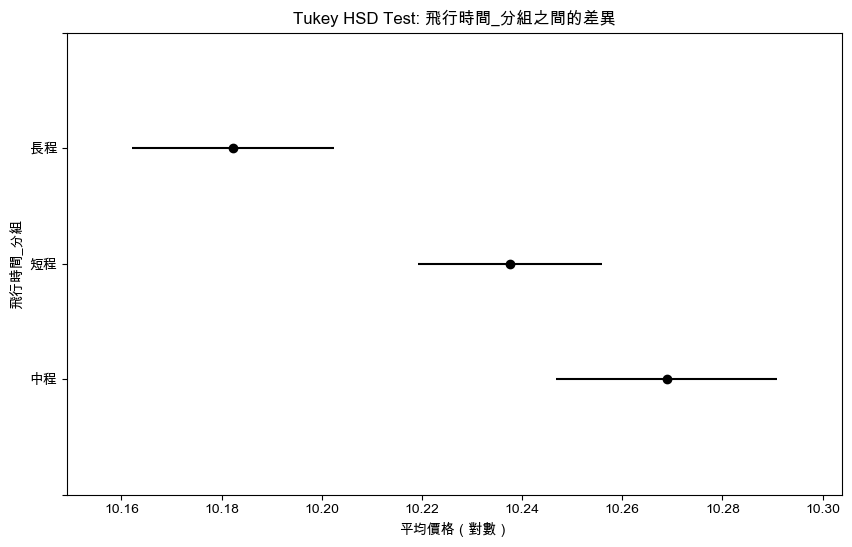

In [4]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 執行 Tukey HSD 測試
tukey = pairwise_tukeyhsd(endog=anova_data['平均價格_log'], groups=anova_data['飛行時間_分組'], alpha=0.05)

# 輸出測試結果
print(tukey)

# 繪製 Tukey HSD 結果
tukey.plot_simultaneous()
plt.title('Tukey HSD Test: 飛行時間_分組之間的差異')
plt.xlabel('平均價格（對數）')
plt.ylabel('飛行時間_分組')
plt.show()